# Monte-Carlo-Simulation

### Config

In [179]:
PATH = "./example_portfolio.csv"
RHO = 0.2
N_SIMS = 10_000
SEED = 79

### Modules

In [180]:
import ctypes
import matplotlib.pyplot as plt
import numpy as np

### C-Interface

In [181]:
class Config(ctypes.Structure):
    _fields_ = [
        ("path", ctypes.c_char * 1024),
        ("rho", ctypes.c_float),
        ("n_sims", ctypes.c_size_t),
        ("seed", ctypes.c_uint)
    ]

class Result(ctypes.Structure):
    _fields_ = [
        ("ms", ctypes.c_float),
        ("L_PF", ctypes.POINTER(ctypes.c_float)),
        ("LR_PF", ctypes.POINTER(ctypes.c_float)),
        ("exact_EL", ctypes.c_float),
        ("EL", ctypes.c_float),
        ("portfolio_size", ctypes.c_size_t),
        ("n_sims", ctypes.c_size_t)
    ]

libmonte = ctypes.CDLL("./libmerton.so")
libmonte.simulate.argtypes = [Config]
libmonte.simulate.restype = Result

### Simulation

In [182]:
config = Config(PATH.encode("utf-8"), RHO, N_SIMS, SEED)
result = libmonte.simulate(config)
l_pf = [float(result.L_PF[i]) for i in range(result.n_sims)]
lr_pf = [float(result.LR_PF[i]) for i in range(result.n_sims)]

print(f"{N_SIMS} simulations took {result.ms:.2f} ms")
print(f"path: {PATH}")
print(f"exact EL: {result.exact_EL:.2f} €")
print(f"EL: {result.EL:.2f} €")
print(f"portfolio_size: {result.portfolio_size}")

10000 simulations took 41.54 ms
path: ./example_portfolio.csv
exact EL: 928200.00 €
EL: 933600.00 €
portfolio_size: 80


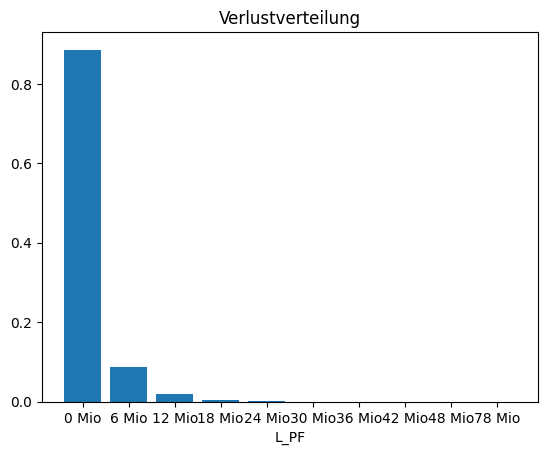

In [183]:
x, y = np.unique(l_pf, return_counts=True)
rel_amount = y/np.sum(y)

fig, ax = plt.subplots()
ax.set_title(f"Verlustverteilung")
names = [f"{int(e/1_000_000)} Mio" for e in x]
ax.bar(names, rel_amount)
ax.set_xlabel("L_PF")
plt.show()